# Introdução aos Ataques DDoS no Dataset CICDDoS2019

O dataset contém múltiplos cenários de ataques, registrados em arquivos CSV, com detalhes sobre tráfego malicioso e legítimo. Abaixo, são listados os períodos de tempo (em horas e minutos) em que os ataques ocorreram, organizados por dia e tipo de ataque.


## Ataques coloetados no dia (03/11)

Abaixo estão os períodos de tempo correspondentes aos ataques registrados em cada arquivo CSV no dia 03/11:

```csv
DrDos_NTP.csv, 10:35 - 10:45
DrDos_DNS.csv, 10:52 - 11:05
DrDos_LDAP.csv, 11:22 - 11:32
DrDos_MSSQL.csv, 11:36 - 11:45
DrDos_NetBIOS.csv, 11:50 - 12:00
DrDos_SNMP.csv, 12:12 - 12:23
DrDos_SSDP.csv, 12:27 - 12:37
DrDos_UDP.csv, 12:45 - 13:09
UDPLag.csv, 13:11 - 13:15
Syn.csv, 13:29 - 13:34
TFTP.csv, 13:35 - 17:15
```

## Ataques coloetados no dia (01/12)

Abaixo estão os períodos de tempo correspondentes aos ataques registrados em cada arquivo CSV no dia 01/12:

```csv
PortMap.csv, 09:43 - 09:51
DrDos_NetBIOS.csv, 10:00 - 10:09
DrDos_LDAP.csv, 10:21 - 10:30
DrDos_MSSQL.csv, 10:33 - 10:42
DrDos_UDP.csv, 10:53 - 11:03
DrDos_UDP-Lag.csv, 11:14 - 11:24
Syn.csv, 11:28 - 17:35
```

# Concatenar os arquivos do dia 01/12 em ordem cronológica

### Concatena 

In [2]:
import pandas as pd
import os

data_path = "data/01-12"

files = [
    "DrDos_DNS.csv", "DrDos_LDAP.csv", "DrDos_MSSQL.csv",
    "DrDos_NetBIOS.csv", "DrDos_NTP.csv", "DrDos_SNMP.csv",
    "DrDos_SSDP.csv", "DrDos_UDP.csv", "Syn.csv",
    "TFTP.csv", "UDPLag.csv"
]

selected_columns = [
    "Flow ID", " Source IP", " Source Port", " Destination IP", 
    " Destination Port", " Protocol", " Timestamp", " Flow Duration",
    " Total Fwd Packets"
]

all_data = []

for file_name in files:
    file_path = os.path.join(data_path, file_name)
    
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path, usecols=selected_columns)
            df = df.rename(columns=lambda x: x.strip())
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
            all_data.append(df)
            print(f"{file_name} processado com {len(df)} linhas.")
        except Exception as e:
            print(f"Erro ao processar {file_name}: {e}")
    else:
        print(f"Arquivo não encontrado: {file_name}")

if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by="Timestamp")
    output_file = os.path.join(data_path, "combined_attacks_01_12.csv")
    final_df.to_csv(output_file, index=False)
    print(f"Arquivo combinado salvo corretamente em ordem cronológica: {output_file}")
else:
    print("Nenhum dado válido encontrado para gerar o arquivo combinado.")


DrDos_DNS.csv processado com 5074413 linhas.
DrDos_LDAP.csv processado com 2181542 linhas.
DrDos_MSSQL.csv processado com 4524498 linhas.
DrDos_NetBIOS.csv processado com 4094986 linhas.
DrDos_NTP.csv processado com 1217007 linhas.
DrDos_SNMP.csv processado com 5161377 linhas.
DrDos_SSDP.csv processado com 2611374 linhas.
DrDos_UDP.csv processado com 3136802 linhas.
Syn.csv processado com 1582681 linhas.
TFTP.csv processado com 20107827 linhas.
UDPLag.csv processado com 370605 linhas.
Arquivo combinado salvo corretamente em ordem cronológica: data/01-12\combined_attacks_01_12.csv


### Plot 

50063112


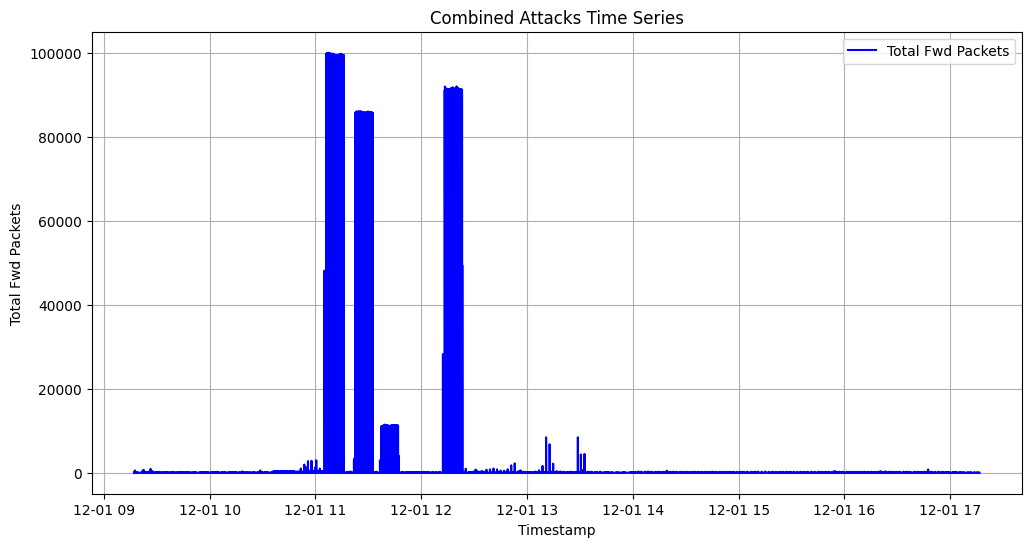

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

combined_df = pd.read_csv("data/01-12/combined_attacks_01_12.csv")
combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])
combined_df.set_index("Timestamp", inplace=True)
combined_df = combined_df.sort_index()
print(len(combined_df))

plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df["Total Fwd Packets"], label="Total Fwd Packets", color="blue")

plt.xlabel("Timestamp")
plt.ylabel("Total Fwd Packets")
plt.title("Combined Attacks Time Series")
plt.legend()
plt.grid()
plt.show()


# Concatenar os arquivos do dia 03/11 em ordem cronológica

In [1]:
import pandas as pd
import os

data_path = "data/03-11"

files = [
    "LDAP.csv", "MSSQL.csv", "NetBIOS.csv", "Portmap.csv",
    "Syn.csv", "UDP.csv", "UDPLag.csv"
]

selected_columns = [
    "Flow ID", " Source IP", " Source Port", " Destination IP", 
    " Destination Port", " Protocol", " Timestamp", " Flow Duration",
    " Total Fwd Packets"
]

all_data = []

for file_name in files:
    file_path = os.path.join(data_path, file_name)
    
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path, usecols=selected_columns)
            df = df.rename(columns=lambda x: x.strip())
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
            all_data.append(df)
            print(f"{file_name} processado com {len(df)} linhas.")
        except Exception as e:
            print(f"Erro ao processar {file_name}: {e}")
    else:
        print(f"Arquivo não encontrado: {file_name}")

if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by="Timestamp")
    output_file = os.path.join(data_path, "combined_attacks_03_11.csv")
    final_df.to_csv(output_file, index=False)
    print(f"Arquivo combinado salvo corretamente em ordem cronológica: {output_file}")
else:
    print("Nenhum dado válido encontrado para gerar o arquivo combinado.")


LDAP.csv processado com 2113234 linhas.
MSSQL.csv processado com 5775786 linhas.
NetBIOS.csv processado com 3455899 linhas.
Portmap.csv processado com 191694 linhas.
Syn.csv processado com 4320541 linhas.
UDP.csv processado com 3782206 linhas.
UDPLag.csv processado com 725165 linhas.
Arquivo combinado salvo corretamente em ordem cronológica: data/03-11\combined_attacks_03_11.csv


### Plot 

20364525


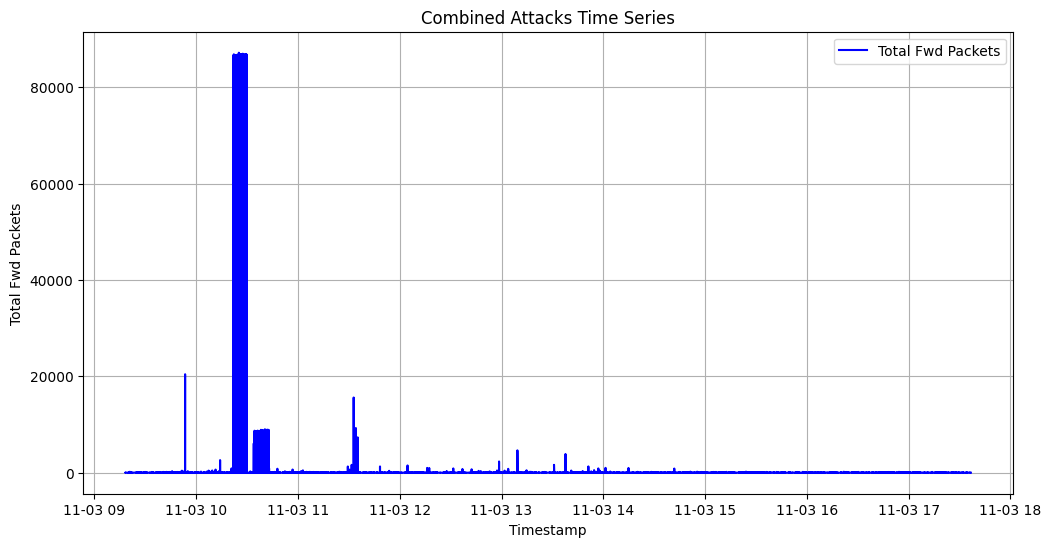

In [5]:

import pandas as pd
import matplotlib.pyplot as plt

combined_df = pd.read_csv("data/03-11/combined_attacks_03_11.csv")
combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])
combined_df.set_index("Timestamp", inplace=True)
combined_df = combined_df.sort_index()
print(len(combined_df))

plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df["Total Fwd Packets"], label="Total Fwd Packets", color="blue")

plt.xlabel("Timestamp")
plt.ylabel("Total Fwd Packets")
plt.title("Combined Attacks Time Series")
plt.legend()
plt.grid()
plt.show()


# Plot de arquivos

50063112


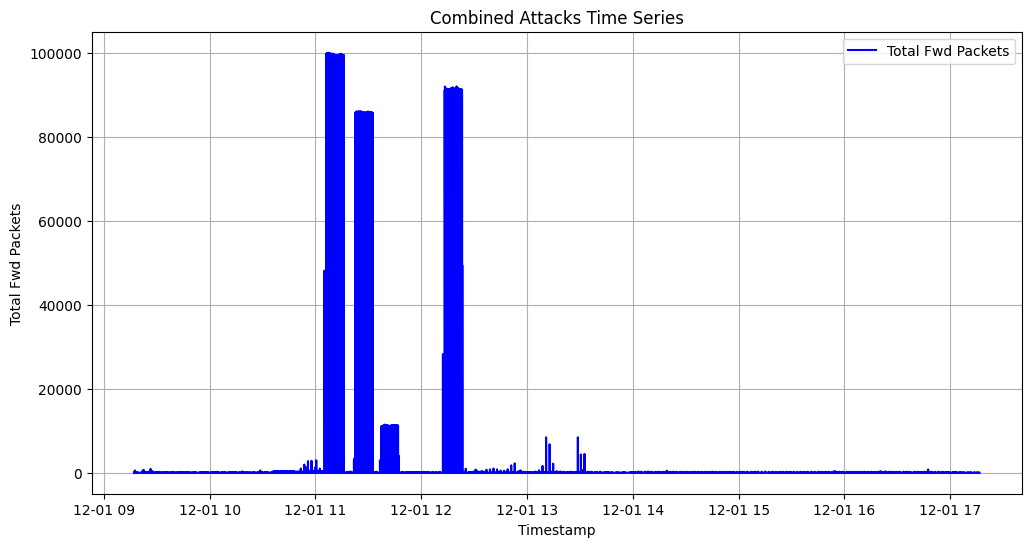

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

combined_df = pd.read_csv("data/combined_attacks_01.csv")
combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])
combined_df.set_index("Timestamp", inplace=True)
combined_df = combined_df.sort_index()
print(len(combined_df))

plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df["Total Fwd Packets"], label="Total Fwd Packets", color="blue")

plt.xlabel("Timestamp")
plt.ylabel("Total Fwd Packets")
plt.title("Combined Attacks Time Series")
plt.legend()
plt.grid()
plt.show()
